In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec,in_signal,n_samples,out_signal=None):
    plt.figure()
    plt.subplot(1,1,1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-',label='input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_signal[:n_samples],'g-',linewidth=2,label='FIR Output')
    plt.legend()                     

Number of samples:  200000


<IPython.core.display.Javascript object>


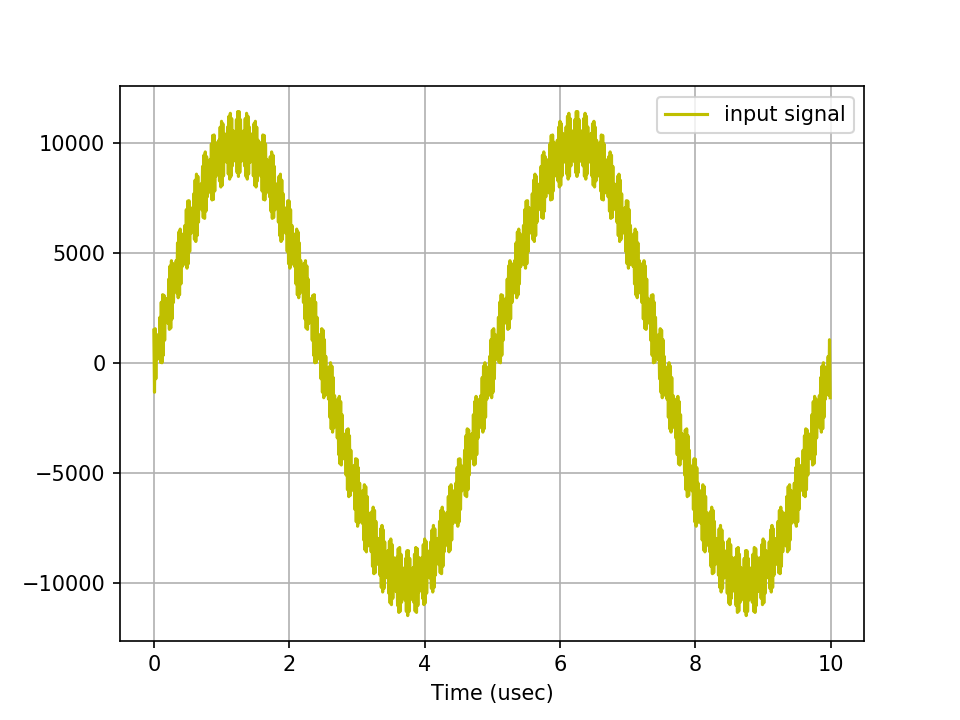

In [2]:
import numpy as np

T=0.002
fs=100e6
n=int(T*fs)
t= np.linspace(0,T,n,endpoint=False)
samples = 10000*np.sin(0.2e6*2*np.pi*t) + 1500*np.cos(46e6*2*np.pi*t)
samples = samples.astype(np.int32)
print('Number of samples: ',len(samples))
plot_to_notebook(t,samples,1000)

SOFTWARE FIR EXECUTION TIME:  0.0874791145324707


<IPython.core.display.Javascript object>


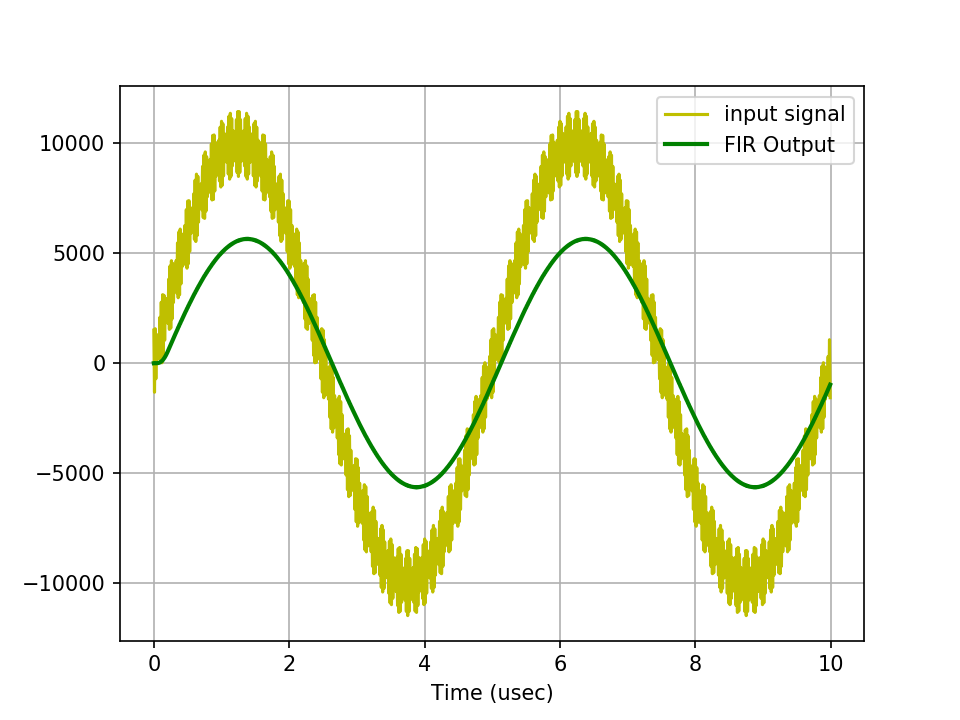

In [5]:
from scipy.signal import lfilter

coeffs = [-255,-260,-312,-288,-144,153,616,1233,1963,2739,3474,4081,4481,4620,4481,4081,3474,2739,1963,1233,616,153,-144,-288,-312,-260,-255]
import time

start_time= time.time()
sw_fir_output = lfilter(coeffs,70e3,samples)
stop_time = time.time()
sw_exec_time = stop_time - start_time
print("SOFTWARE FIR EXECUTION TIME: ",sw_exec_time)

plot_to_notebook(t,samples,1000,out_signal= sw_fir_output)


In [6]:
from pynq import Overlay
import pynq.lib.dma

#Load the overlay

overlay = Overlay('FIR_filter.bit')
overlay?
#Load the FIR DMA
dma = overlay.filter.fir_dma


Hardware FIR execution time 0.0036940574645996094
Hardware acceleration factor :  23.681037821092037


<IPython.core.display.Javascript object>


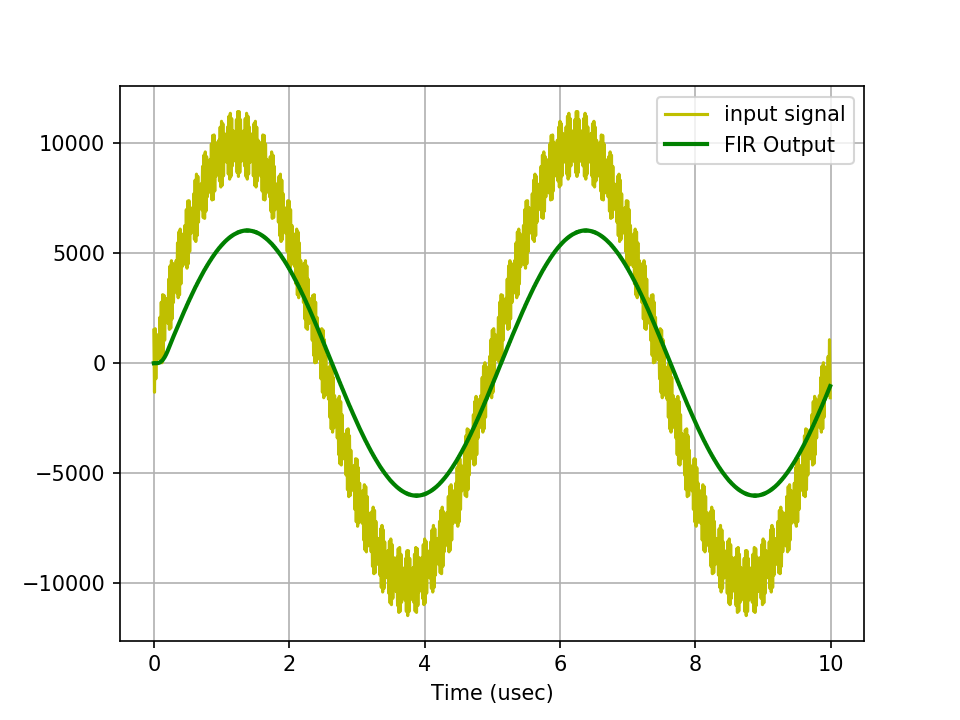

In [8]:
from pynq import Xlnk # it allows us to make buffers 
import numpy as np

xlnk= Xlnk()
in_buffer= xlnk.cma_array(shape=(n,),dtype= np.int32)
out_buffer= xlnk.cma_array(shape=(n,),dtype= np.int32)

np.copyto(in_buffer,samples)

import time
start_time = time.time()
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()
stop_time = time.time()

hw_exec_time = stop_time - start_time

print("Hardware FIR execution time",hw_exec_time)
print("Hardware acceleration factor : ",sw_exec_time/hw_exec_time)

plot_to_notebook(t,samples,1000,out_signal=out_buffer)
in_buffer.close()
out_buffer.close()